In [ ]:
import ee
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive

drive.mount('/content/drive')
project_path = '/content/drive/My Drive/FuelsData3'
os.chdir(project_path)
print("Now working in:", os.getcwd())


ee.Authenticate()
ee.Initialize(project='eofm-benchmark')

Mounted at /content/drive
Now working in: /content/drive/My Drive/FuelsData3


In [ ]:
band_map = {
    'bands':['B2','B3','B4','B5','B6','B7'],
    'band_names':['BLUE','GREEN','RED','NIR','SWIR1','SWIR2']
}

FM40_YEAR = "2023" # 2022 or 2023

YEARS  = [
    2020,
    2021,
    2022,
    2023,
    2024
]

SAMPLING_MODE = "PARENT" # "ORIGINAL" or "PARENT"
STATE = "California"
SEED = 25 # tried 42
NUMPTS = 4000
SCALE = 30
CLOUD_COVER_PCT= 20

In [ ]:
fbfm40 = (ee.ImageCollection('projects/pyregence-ee/assets/conus/landfire/fbfm40'))
version = fbfm40.get('version').getInfo()

states = ee.FeatureCollection("TIGER/2018/States")
state = states.filter(ee.Filter.eq('NAME',STATE))

pyromes = ee.FeatureCollection('projects/pyregence-ee/assets/Pyromes_CONUS_20200206')

DEM Setup

In [ ]:
def get_elevation(geometry):
  dem = ee.Image('USGS/SRTMGL1_003') \
    .clip(geometry) \
    .select('elevation')

  slope = ee.Terrain.slope(dem).rename('slope')
  aspect = ee.Terrain.aspect(dem).rename('aspect')

  mtpi = ee.Image('CSP/ERGo/1_0/Global/SRTM_mTPI') \
    .clip(geometry) \
    .select('elevation').rename('mtpi')
  return dem, slope, aspect, mtpi

Spectral Indices Setup

In [ ]:
C1 = 6
C2 = 7.5
L = 1
g = 2.5

L2 = 0.5

b1 = 0.2043
b2 = 0.4158
b3 = 0.5524
b4 = 0.5741
b5 = 0.3124
b6 = 0.2303

g1 = -0.1603
g2 = 0.2819
g3 = -0.4934
g4 = 0.7940
g5 = -0.0002
g6 = -0.1446

w1 = 0.0315
w2 = 0.2021
w3 = 0.3102
w4 = 0.1594
w5 = -0.6806
w6 = -0.6109

index_list = [
    'NDVI',
    'EVI',
    'SAVI',
    'MSAVI',
    'NDMI',
    'TCB',
    'TCG',
    'TSW',
    'VARI',
    'NBR'
]

def ndvi(image):
  ndvi = image.normalizedDifference(['B5','B4']).rename('NDVI')
  return image.addBands(ndvi)

def evi(image):
  evi = image.expression(
      'g * ((NIR - RED) / (NIR + C1 * RED - C2 * BLUE + L))',
      {
          'g':g,
          'C1':C1,
          'C2':C2,
          'L':L,
          'NIR':image.select('B5'),
          'RED':image.select('B4'),
          'BLUE':image.select('B2')
      }
  ).rename('EVI')
  return image.addBands(evi)

def savi(image):
  savi = image.expression(
      '(1 + L) * (NIR - RED) / (NIR + RED +  L)',
      {
          'L':L2,
          'NIR':image.select('B5'),
          'RED':image.select('B4')
      }
  ).rename('SAVI')
  return image.addBands(savi)

def msavi(image):
  msavi = image.expression(
       '(2.0 * NIR + 1 - (((2 * NIR + 1) ** 2) - 8 * (NIR - RED)) ** 0.5) / 2',
       {
          'NIR':image.select('B5'),
          'RED':image.select('B4')
       }

  ).rename('MSAVI')
  return image.addBands(msavi)
def ndmi(image):
  ndmi = image.expression(
      '(NIR - SWIR1) / (NIR + SWIR1)',
      {
          'NIR':image.select('B5'),
          'SWIR1':image.select('B6')
      }
  ).rename('NDMI')
  return image.addBands(ndmi)
def tcb(image):
  tcb = image.expression(
      '(b1 * BLUE) + (b2 * RED) + (b3 * GREEN) + (b4 * NIR) + (b5 * SWIR1) + (b6 * SWIR2)',
      {
          'b1':b1,
          'b2':b2,
          'b3':b3,
          'b4':b4,
          'b5':b5,
          'b6':b6,
          'BLUE':image.select('B2'),
          'GREEN':image.select('B3'),
          'RED':image.select('B4'),
          'NIR':image.select('B5'),
          'SWIR1':image.select('B6'),
          'SWIR2':image.select('B7'),
      }
  ).rename('TCB')
  return image.addBands(tcb)

def tcg(image):
  tcg = image.expression(
      '(g1 * BLUE) + (g2 * RED) + (g3 * GREEN) + (g4 * NIR) + (g5 * SWIR1) + (g6 * SWIR2)',
      {
          'g1':g1,
          'g2':g2,
          'g3':g3,
          'g4':g4,
          'g5':g5,
          'g6':g6,
          'BLUE':image.select('B2'),
          'GREEN':image.select('B3'),
          'RED':image.select('B4'),
          'NIR':image.select('B5'),
          'SWIR1':image.select('B6'),
          'SWIR2':image.select('B7')
      }
  ).rename('TCG')
  return image.addBands(tcg)

def tsw(image):
  tsw = image.expression(
      '(w1 * BLUE) + (w2 * RED) + (w3 * GREEN) + (w4 * NIR) + (w5 * SWIR1) + (w6 * SWIR2)',
      {
          'w1':w1,
          'w2':w2,
          'w3':w3,
          'w4':w4,
          'w5':w5,
          'w6':w6,
          'BLUE':image.select('B2'),
          'GREEN':image.select('B3'),
          'RED':image.select('B4'),
          'NIR':image.select('B5'),
          'SWIR1':image.select('B6'),
          'SWIR2':image.select('B7')
      }
  ).rename('TSW')
  return image.addBands(tsw)

def vari(image):
  vari = image.expression(
      '(GREEN - RED) / (GREEN + RED - BLUE)',
      {
          'BLUE':image.select('B2'),
          'GREEN':image.select('B3'),
          'RED':image.select('B4')
      }
  ).rename('VARI')
  return image.addBands(vari)

def nbr(image):
  nbr = image.expression(
      '(NIR - SWIR2) / (NIR + SWIR2)',
      {
          'NIR':image.select('B5'),
          'SWIR2':image.select('B6'),
      }
  ).rename('NBR')
  return image.addBands(nbr)

def compute_indices(image):
  image = ndvi(image)
  image = evi(image)
  image = savi(image)
  image = msavi(image)
  image = ndmi(image)
  image = tcb(image)
  image = tcg(image)
  image = tsw(image)
  image = vari(image)
  image = nbr(image)

  return image
months = [1,2,3,4,5,6,7,8,9,10,11,12]

def monthly_composite(year,month,geometry):
  composite = ee.ImageCollection('NASA/HLS/HLSL30/v002') \
      .filter(ee.Filter.lt('CLOUD_COVERAGE',CLOUD_COVER_PCT)) \
      .filter(ee.Filter.calendarRange(year, year, 'year')) \
      .filter(ee.Filter.calendarRange(month,month,'month')) \
      .filterBounds(geometry) \
      .mosaic()

  return composite

def create_monthly_composites(year, geometry):
  monthMap = ee.List(months)

  compositeCollection = ee.ImageCollection.fromImages(
      monthMap.map(lambda month: monthly_composite(year,month,geometry))
  )
  return compositeCollection

def seasonal_composite(month,geometry):
  month = ee.Date(month)
  composite = ee.ImageCollection('NASA/HLS/HLSL30/v002') \
      .filter(ee.Filter.lt('CLOUD_COVERAGE',CLOUD_COVER_PCT)) \
      .filter(ee.Filter.date(month,month.advance(3,'month'))) \
      .filterBounds(geometry) \
      .select(['B2','B3','B4','B5','B6','B7']) \
      .median()
  return composite
def create_seasonalComposites(year,geometry):
  start_months = [
          ee.Date(f'{year}-01-01'),
          ee.Date(f'{year}-04-01'),
          ee.Date(f'{year}-07-01'),
          ee.Date(f'{year}-10-01'),
      ]


  im1 = ee.ImageCollection('NASA/HLS/HLSL30/v002').filter(ee.Filter.lt('CLOUD_COVERAGE',CLOUD_COVER_PCT)).filter(ee.Filter.date(start_months[0],start_months[0].advance(3,'month'))).filterBounds(geometry).select(['B2','B3','B4','B5','B6','B7'],[band + '_winter' for band in ['B2','B3','B4','B5','B6','B7']]).median()
  im2 = ee.ImageCollection('NASA/HLS/HLSL30/v002').filter(ee.Filter.lt('CLOUD_COVERAGE',CLOUD_COVER_PCT)).filter(ee.Filter.date(start_months[1],start_months[1].advance(3,'month'))).filterBounds(geometry).select(['B2','B3','B4','B5','B6','B7'],[band + '_spring' for band in ['B2','B3','B4','B5','B6','B7']]).median()
  im3 = ee.ImageCollection('NASA/HLS/HLSL30/v002').filter(ee.Filter.lt('CLOUD_COVERAGE',CLOUD_COVER_PCT)).filter(ee.Filter.date(start_months[2],start_months[2].advance(3,'month'))).filterBounds(geometry).select(['B2','B3','B4','B5','B6','B7'],[band + '_summer' for band in ['B2','B3','B4','B5','B6','B7']]).median()
  im4 = ee.ImageCollection('NASA/HLS/HLSL30/v002').filter(ee.Filter.lt('CLOUD_COVERAGE',CLOUD_COVER_PCT)).filter(ee.Filter.date(start_months[3],start_months[3].advance(3,'month'))).filterBounds(geometry).select(['B2','B3','B4','B5','B6','B7'],[band + '_fall' for band in ['B2','B3','B4','B5','B6','B7']]).median()

  seasonalComposites = im1.addBands(im2).addBands(im3).addBands(im4)
  # seasonalComposites = ee.ImageCollection.fromImages(
  #     start_months.map(lambda month: ee.Image(seasonal_composite(month,geometry)))
  # )
  return seasonalComposites

def merge_bands(image,previous):
  return ee.Image(previous).addBands(image)

def get_spectral_data(year,geometry):
  compositeCollection = create_monthly_composites(year,geometry)
  compositeCollectionWithIndices = compositeCollection.map(compute_indices)

  spectralIndexMedians = compositeCollectionWithIndices.select(index_list,[index + '_median' for index in index_list]).median()
  spectralIndexMin = compositeCollectionWithIndices.select(index_list,[index + '_min' for index in index_list]).min()
  spectralIndexMax = compositeCollectionWithIndices.select(index_list,[index + '_max' for index in index_list]).max()

  hlsCompositeBands = create_seasonalComposites(year,geometry)

  return hlsCompositeBands, spectralIndexMedians, spectralIndexMin, spectralIndexMax

Climate Variables Setup

In [ ]:
# prism_normals = ee.ImageCollection('OREGONSTATE/PRISM/Norm91m')

# climatenormsals = prism_normals.select(['ppt','tmean','tmin','tmax','tdmean','vpdmin','vpdmax','solclear','solslope','soltotal'])

# prism = ee.ImageCollection('OREGONSTATE/PRISM/AN81m').select(['ppt','tmean','tmin','tmax','tdmean','vpdmin','vpdmax'])

def get_climate_variables(year,geometry):
  climate_norm_variables = ['ppt','tmean','tmin','tmax','tdmean','vpdmin','vpdmax','solclear','solslope','soltotal']
  climatenormals = ee.ImageCollection('OREGONSTATE/PRISM/Norm91m') \
    .filterBounds(geometry) \
    .first() \
    .select(climate_norm_variables,[climvar + '_norm' for climvar in climate_norm_variables])


  prism = ee.ImageCollection('OREGONSTATE/PRISM/AN81m') \
    .filter(ee.Filter.calendarRange(year, year, 'year')) \
    .filterBounds(geometry) \
    .select(['ppt','tmean','tmin','tmax','tdmean','vpdmin','vpdmax']) \
    .mean()

  return climatenormals, prism


Biophysical Variables Setup

In [ ]:
def get_biophysical_vars(year,geometry):
  bio = ee.ImageCollection("LANDFIRE/Vegetation/BPS/v1_4_0") \
    .filterBounds(geometry).mosaic()
  evc = ee.ImageCollection('LANDFIRE/Vegetation/EVC/v1_4_0') \
    .filterBounds(geometry).mosaic()
  evt = ee.ImageCollection('LANDFIRE/Vegetation/EVT/v1_4_0') \
    .filterBounds(geometry).mosaic()
  evh = ee.ImageCollection('LANDFIRE/Vegetation/EVH/v1_4_0') \
    .filterBounds(geometry).mosaic()
  esp = ee.Image('LANDFIRE/Vegetation/ESP/v1_2_0/CONUS').clip(geometry)

  bio_combine = bio.addBands(evc).addBands(evt).addBands(evh).addBands(esp)

  return bio_combine


In [ ]:
def get_alphaearth_embeddings(year,geometry):
  alphaearth = ee.ImageCollection('GOOGLE/SATELLITE_EMBEDDING/V1/ANNUAL') \
    .filter(ee.Filter.calendarRange(year, year, 'year')) \
    .filterBounds(geometry) \
    .mosaic()
  return alphaearth


Extract Data Yearly

In [ ]:
# zone = 18
# year = 2020

# fbfm40 = ee.ImageCollection('projects/pyregence-ee/assets/conus/landfire/fbfm40').filter(ee.Filter.calendarRange(2023, 2023, 'year')).first().select('FBFM40')

# from_vals = [
#     91,92,93,98,99,
#     101,102,103,104,105,106,107,108,109,
#     121,122,123,124,
#     141,142,143,144,145,146,147,148,149,
#     161,162,163,164,165,
#     181,182,183,184,185,186,187,188,189,
#     201,202,203,204
# ]

# to_vals = [
#     1,1,1,1,1,
#     2,2,2,2,2,2,2,2,2,
#     3,3,3,3,
#     4,4,4,4,4,4,4,4,4,
#     5,5,5,5,5,
#     6,6,6,6,6,6,6,6,6,
#     7,7,7,7
# ]

# pyrome = pyromes.filter(ee.Filter.eq('PYROME', zone))

# dem_sample, slope_sample, aspect_sample, mtpi_sample = get_elevation(pyrome.geometry())
# elevation_features = dem_sample.addBands(slope_sample).addBands(aspect_sample).addBands(mtpi_sample)

# alphaearth_sample = get_alphaearth_embeddings(year,pyrome.geometry())

# climate_norms_sample, climate_annual_sample = get_climate_variables(year,pyrome.geometry())
# climate_features = climate_norms_sample.addBands(climate_annual_sample)

# hlsCompositeBands_sample, spectralIndexMedians_sample, spectralIndexMin_sample, spectralIndexMax_sample = get_spectral_data(year,pyrome.geometry())
# spectral_features = hlsCompositeBands_sample.addBands(spectralIndexMedians_sample).addBands(spectralIndexMin_sample).addBands(spectralIndexMax_sample)


# # Apply remap
# remapped_fbfm40 = fbfm40.remap(from_vals, to_vals)

# remapped_fbfm40 = remapped_fbfm40.rename('FBFM40Parent')
# remapped_fbfm40 = remapped_fbfm40.addBands(fbfm40)


# dataset = remapped_fbfm40.addBands(elevation_features).addBands(alphaearth_sample).addBands(spectral_features).addBands(climate_features)
# dataset = remapped_fbfm40.addBands(spectral_features)


sample points

In [ ]:
# numpts = 3000
# seed = SEED

# samples = dataset.stratifiedSample(
#     numPoints=numpts,
#     classBand="FBFM40Parent",    # band name of remapped image
#     region=pyrome.geometry(), # full image extent
#     scale=30,
#     classValues=[1,2,3,4,5,6,7],
#     classPoints=[numpts,numpts,numpts,numpts,numpts,numpts,numpts],
#     geometries=True,
#     seed = seed
# )

export points

In [ ]:
# task = ee.batch.Export.table.toDrive(
#     collection=samples,
#     description=f'stratified_sample_fbfm40_30m_{zone}_{year}',
#     fileFormat='CSV',
#     folder='FuelsData'
# )
# task.start()

# print("Export started: check Earth Engine Tasks tab in Code Editor")

In [ ]:
def collect_and_export_data(year,zone):
  fbfm40 = ee.ImageCollection('projects/pyregence-ee/assets/conus/landfire/fbfm40').filter(ee.Filter.calendarRange(year, year, 'year')).first().select('FBFM40')
  pyromes = ee.FeatureCollection('projects/pyregence-ee/assets/Pyromes_CONUS_20200206')

  from_vals = [
      91,92,93,98,99,
      101,102,103,104,105,106,107,108,109,
      121,122,123,124,
      141,142,143,144,145,146,147,148,149,
      161,162,163,164,165,
      181,182,183,184,185,186,187,188,189,
      201,202,203,204
  ]

  to_vals = [
      1,1,1,1,1,
      2,2,2,2,2,2,2,2,2,
      3,3,3,3,
      4,4,4,4,4,4,4,4,4,
      5,5,5,5,5,
      6,6,6,6,6,6,6,6,6,
      7,7,7,7
  ]

  pyrome = pyromes.filter(ee.Filter.eq('PYROME', zone))

  dem_sample, slope_sample, aspect_sample, mtpi_sample = get_elevation(pyrome.geometry())
  elevation_features = dem_sample.addBands(slope_sample).addBands(aspect_sample).addBands(mtpi_sample)

  alphaearth_sample = get_alphaearth_embeddings(year,pyrome.geometry())

  climate_norms_sample, climate_annual_sample = get_climate_variables(year,pyrome.geometry())
  climate_features = climate_norms_sample.addBands(climate_annual_sample)

  hlsCompositeBands_sample, spectralIndexMedians_sample, spectralIndexMin_sample, spectralIndexMax_sample = get_spectral_data(year,pyrome.geometry())
  spectral_features = hlsCompositeBands_sample.addBands(spectralIndexMedians_sample).addBands(spectralIndexMin_sample).addBands(spectralIndexMax_sample)

  bio_features = get_biophysical_vars(year,pyrome.geometry())


  # Apply remap
  remapped_fbfm40 = fbfm40.remap(from_vals, to_vals)

  remapped_fbfm40 = remapped_fbfm40.rename('FBFM40Parent')
  remapped_fbfm40 = remapped_fbfm40.addBands(fbfm40)


  dataset = remapped_fbfm40.addBands(elevation_features).addBands(alphaearth_sample).addBands(spectral_features).addBands(climate_features).addBands(bio_features)

  numpts = 3000
  seed = SEED

  samples = dataset.stratifiedSample(
      numPoints=numpts,
      classBand="FBFM40Parent",    # band name of remapped image
      region=pyrome.geometry(), # full image extent
      scale=30,
      classValues=[1,2,3,4,5,6,7],
      classPoints=[numpts,numpts,numpts,numpts,numpts,numpts,numpts],
      geometries=True,
      seed = seed
  )

  task = ee.batch.Export.table.toDrive(
      collection=samples,
      description=f'stratified_sample_fbfm40_30m_{zone}_{year}',
      fileFormat='CSV',
      folder='FuelsData3'
  )
  task.start()

  print("Export started: check Earth Engine Tasks tab in Code Editor")


In [ ]:
years = [2020,2021,2022,2023]
# zones = [6, 17, 18, 19, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 41, 77, 78]
zones = [30,31,32,33,34,28,29,27,35,41]

for year in years:
  for zone in zones:
    collect_and_export_data(year,zone)

/usr/local/lib/python3.12/dist-packages/ee/deprecation.py:207: DeprecationWarning: 

Attention required for OREGONSTATE/PRISM/AN81m! You are using a deprecated asset.
To make sure your code keeps working, please update it.
Learn more: https://developers.google.com/earth-engine/datasets/catalog/OREGONSTATE_PRISM_AN81m

  warnings.warn(warning, category=DeprecationWarning)


Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks tab in Code Editor
Export started: check Earth Engine Tasks

In [ ]:
def fbfm40_class_dist(zone,year):
  fbfm40 = ee.ImageCollection('projects/pyregence-ee/assets/conus/landfire/fbfm40').filter(ee.Filter.calendarRange(year, year, 'year')).first().select('FBFM40')
  pyromes = ee.FeatureCollection('projects/pyregence-ee/assets/Pyromes_CONUS_20200206')

  from_vals = [
      91,92,93,98,99,
      101,102,103,104,105,106,107,108,109,
      121,122,123,124,
      141,142,143,144,145,146,147,148,149,
      161,162,163,164,165,
      181,182,183,184,185,186,187,188,189,
      201,202,203,204
  ]

  to_vals = [
      1,1,1,1,1,
      2,2,2,2,2,2,2,2,2,
      3,3,3,3,
      4,4,4,4,4,4,4,4,4,
      5,5,5,5,5,
      6,6,6,6,6,6,6,6,6,
      7,7,7,7
  ]

  pyrome = pyromes.filter(ee.Filter.eq('PYROME', zone))

  # Apply remap
  remapped_fbfm40 = fbfm40.remap(from_vals, to_vals)

  remapped_fbfm40 = remapped_fbfm40.rename('FBFM40Parent')
  remapped_fbfm40 = remapped_fbfm40.addBands(fbfm40)

  histogramDictionary = remapped_fbfm40.select('FBFM40Parent').reduceRegion(
      **{
          'reducer':ee.Reducer.frequencyHistogram(),
          'geometry':pyrome.geometry(),
          'scale':30,
          'maxPixels':1e10
      }
  )
  histogram = histogramDictionary.getInfo()
  classes = list(histogram['FBFM40Parent'].keys())
  counts = np.array(list(histogram['FBFM40Parent'].values()))

  counts = counts / np.sum(counts)
  plt.bar(classes,counts)
  plt.title(f'Zone {zone} FBFM40 Reduced Classes')
  plt.show()

  return histogram['FBFM40Parent']

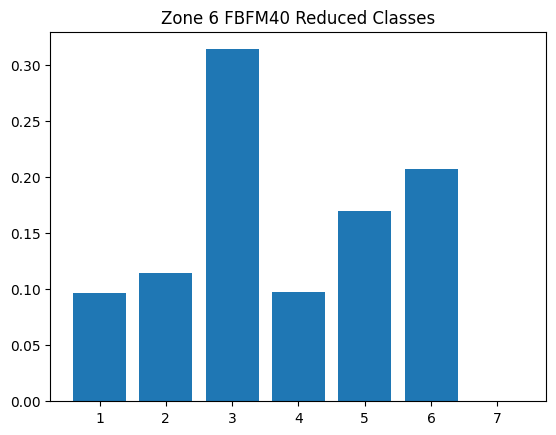

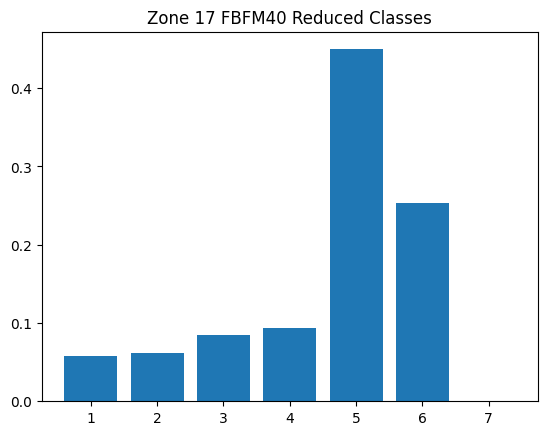

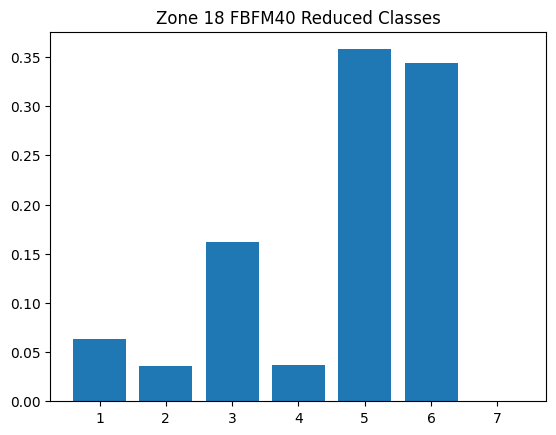

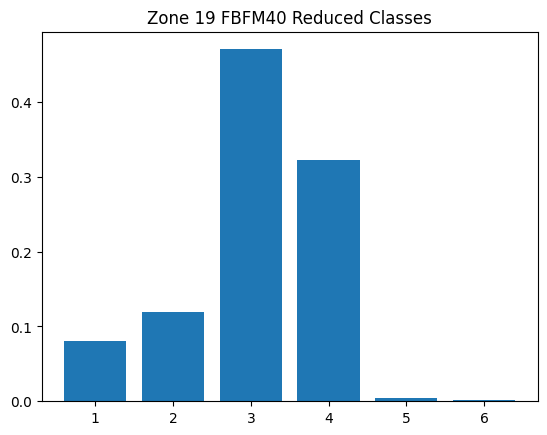

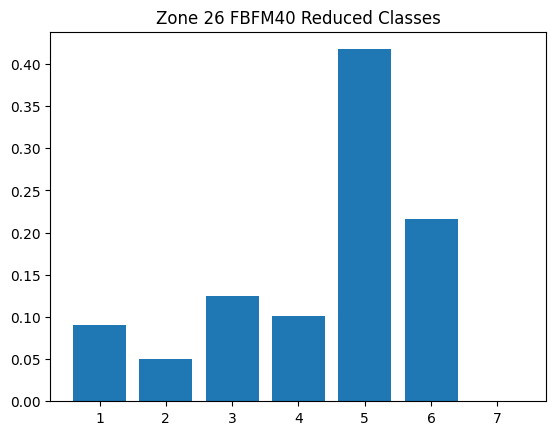

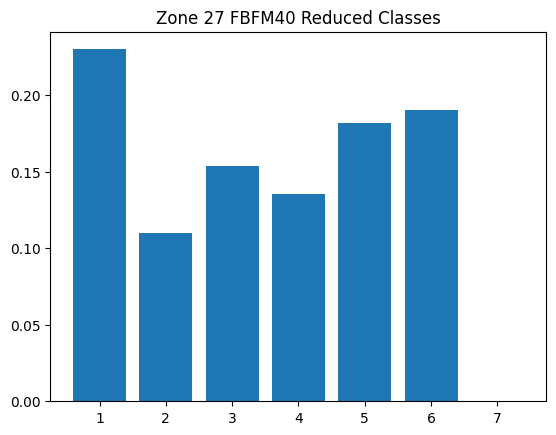

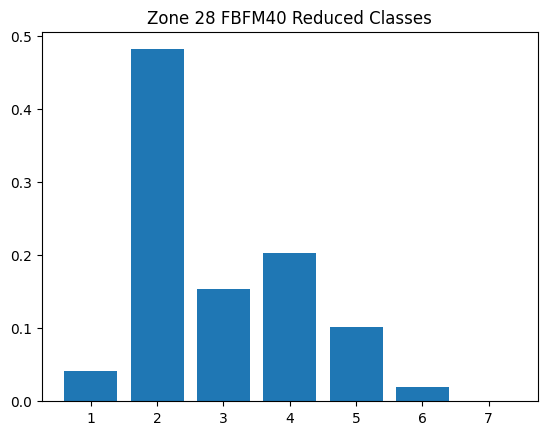

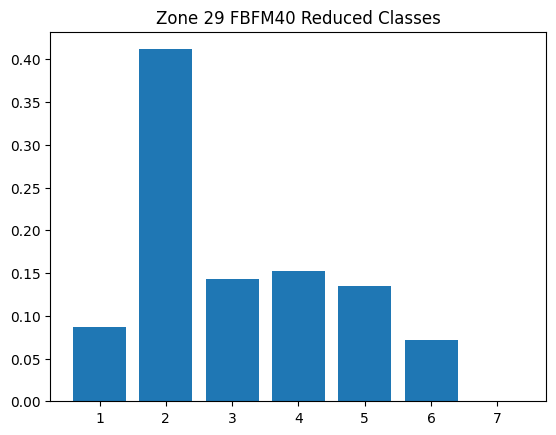

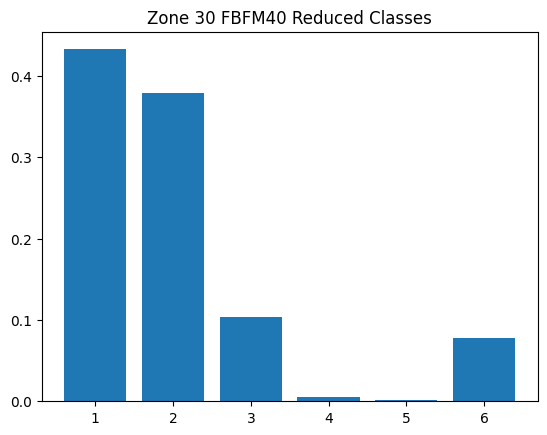

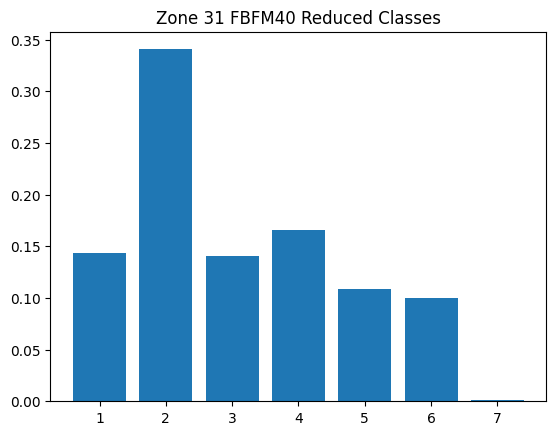

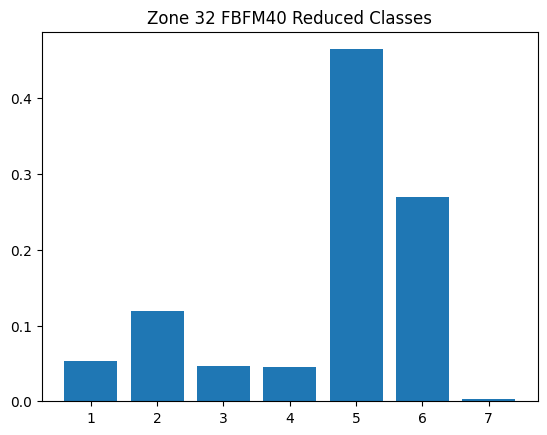

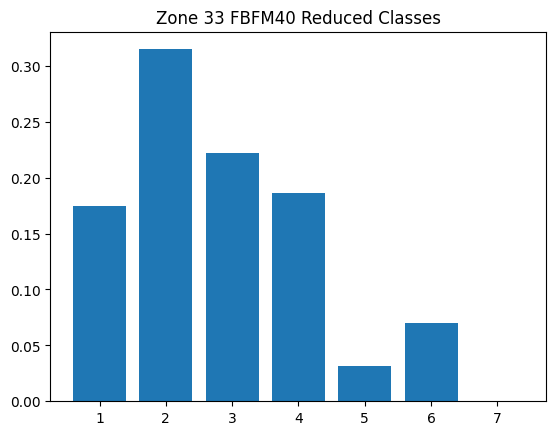

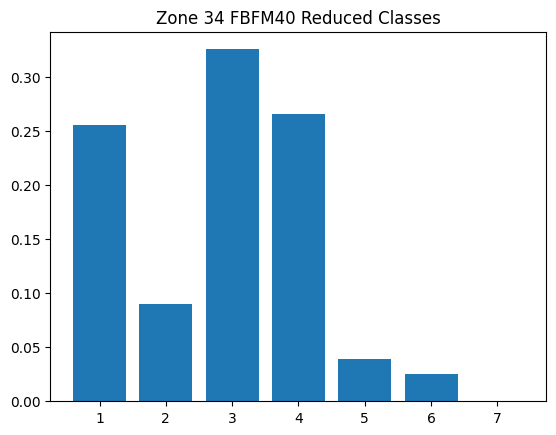

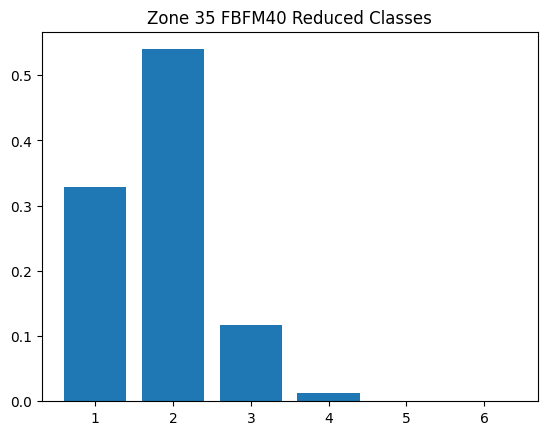

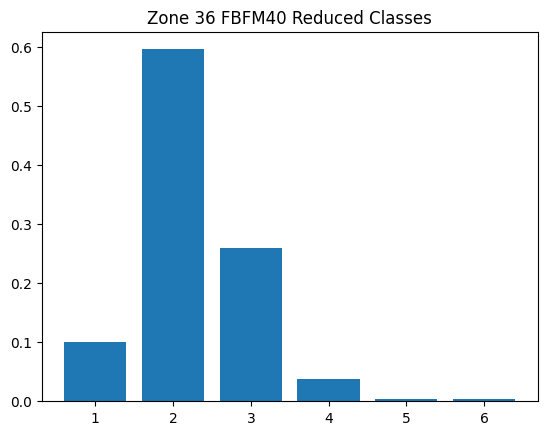

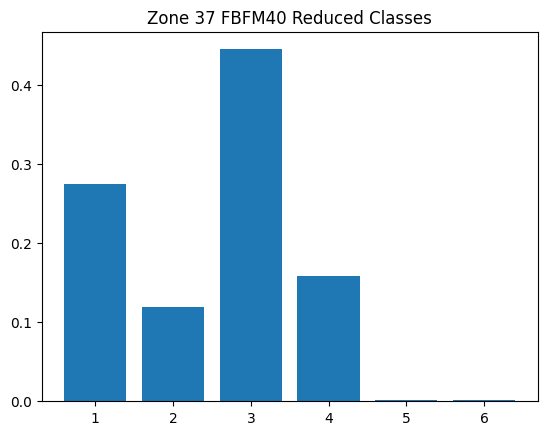

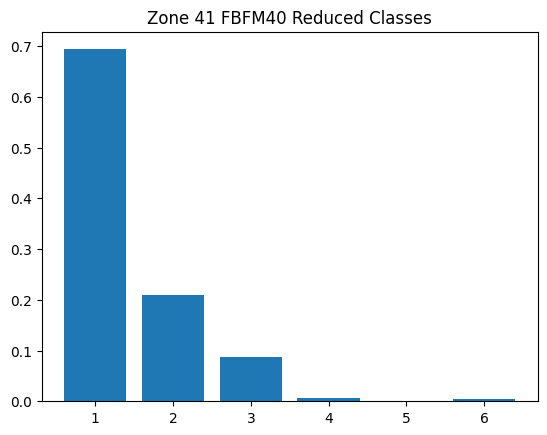

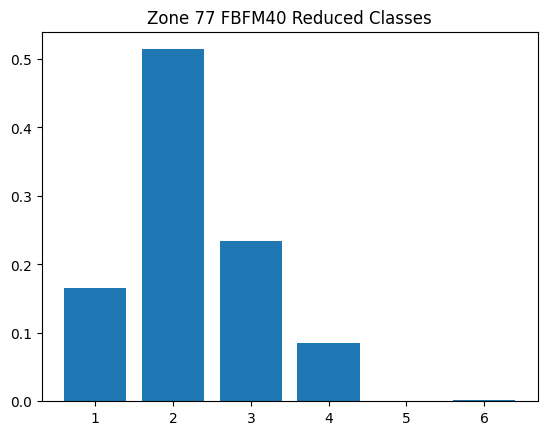

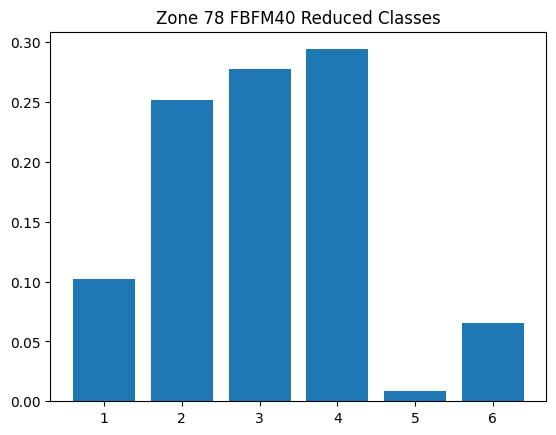

In [ ]:
year = 2023
zones = [6, 17, 18, 19, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 41, 77, 78]

parent_classes = [1,2,3,4,5,6,7]
zone_dists = {}
for zone in zones:
  histogram = fbfm40_class_dist(zone,year)
  classes = list(histogram.keys())
  counts = np.array(list(histogram.values()))
  counts = counts / np.sum(counts)

  year_dist = dict(zip(classes,counts))

  for parent_class in parent_classes:
    if not parent_class in year_dist.keys():
      year_dist[parent_class] = 0
  zone_dists[zone] = year_dist

In [ ]:
# df = pd.DataFrame.from_dict(zone_dists,orient='index')
# df.to_csv(f'/content/drive/My Drive/FuelsData3/fuel_class_distributions_{year}.csv')

In [ ]:
year = 2023

bio = ee.ImageCollection("LANDFIRE/Vegetation/BPS/v1_4_0").first()
evt = ee.ImageCollection('LANDFIRE/Vegetation/EVT/v1_4_0').first()

bps_classes = bio.get('BPS_class_values').getInfo()
bps_class_names = bio.get('BPS_class_names').getInfo()

print(bps_classes)
print(bps_class_names)

print(evt.propertyNames().getInfo())

evt_classes = evt.get('EVT_class_names').getInfo()
evt_class_names =  evt.get('EVT_class_values').getInfo()

print(evt_classes)
print(evt_class_names)

[11, 12, 31, 381, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452, 453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496, 497, 498, 499, 500, 501, 502, 503, 504, 505, 506, 507, 508, 509, 510, 511, 512, 513, 514, 515, 516, 517, 518, 519, 520, 521, 522, 523, 524, 525, 526, 527, 528, 529, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541, 542, 543, 544, 545, 546, 547, 548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 57